In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE, RFECV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import roc_curve, auc



In [2]:
data = pd.read_csv('insurance.csv')

median_cost = data['insurance_cost'].median()
data['insurance_cost_binary'] = (data['insurance_cost'] > median_cost).astype(int)
data.drop('insurance_cost', axis=1, inplace=True)

data.head()


age  gender     bmi  children smoker     region  insurance_cost_binary
0   18    male  33.770         1     no  southeast                      0
1   18    male  34.100         0     no  southeast                      0
2   18  female  26.315         0     no  northeast                      0
3   18  female  38.665         2     no  northeast                      0
4   18  female  35.625         0     no  northeast                      0

In [3]:
categorical_features = ['gender', 'smoker', 'region']
numerical_features = ['age', 'bmi', 'children']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='if_binary'), categorical_features)
    ]
)

pca = PCA()

rfe_estimator = RandomForestClassifier()
rfe = RFE(estimator=rfe_estimator)


In [4]:
X = data.drop('insurance_cost_binary', axis=1)
y = data['insurance_cost_binary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

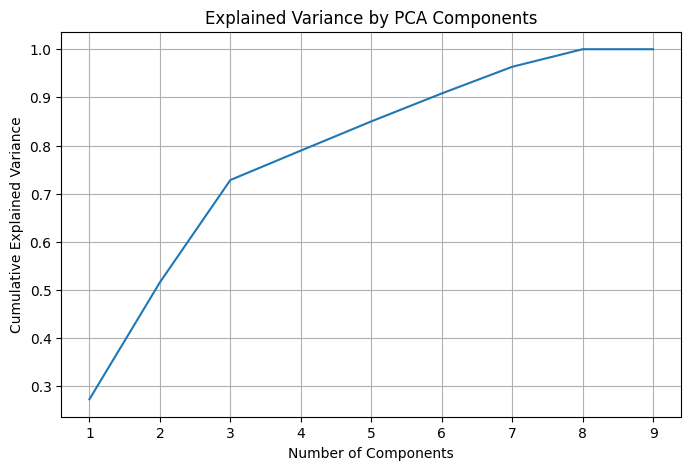

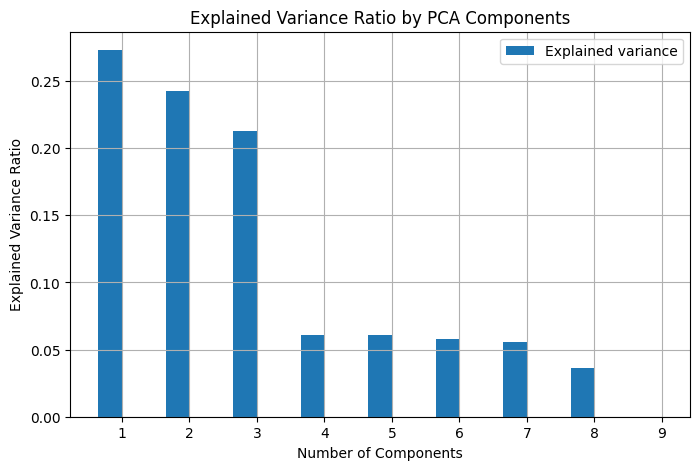

In [5]:
pca.fit(preprocessor.fit_transform(X_train))

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by PCA Components')
plt.grid(True)
plt.xticks(range(1, len(pca.explained_variance_ratio_) + 1))
plt.show()

plt.figure(figsize=(8, 5))
bar_width = 0.35
index = np.arange(len(pca.explained_variance_ratio_))
plt.bar(index, pca.explained_variance_ratio_, bar_width, label='Explained variance')

plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio by PCA Components')
plt.xticks(index + bar_width / 2, (index + 1))
plt.grid(True)
plt.legend()
plt.show()

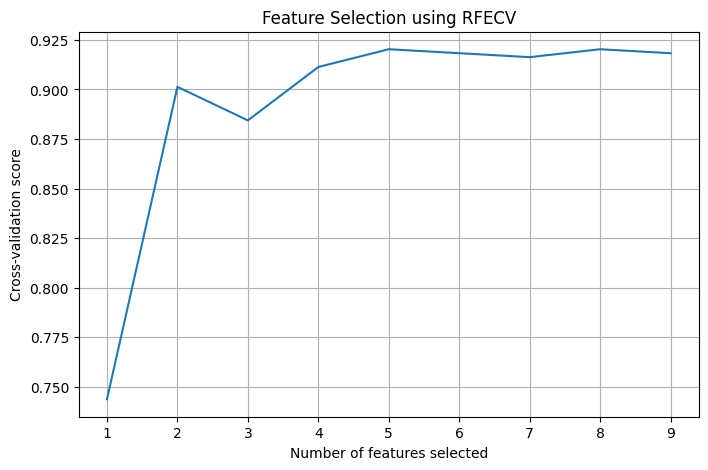

In [6]:
rfecv = RFECV(estimator=rfe_estimator, step=1, cv=5, scoring='accuracy')

rfecv.fit(preprocessor.fit_transform(X_train), y_train)

plt.figure(figsize=(8, 5))
plt.xlabel("Number of features selected")
plt.ylabel("Cross-validation score")
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'])
plt.title('Feature Selection using RFECV')
plt.grid(True)
plt.show()


In [7]:
svm_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('pca', pca),
    ('svm', SVC())
])

rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('rfe', rfe),
    ('rf', RandomForestClassifier())
])


In [8]:
param_grid_svm = {
    'pca__n_components': [2, 3, 4, 5],
    'svm__C': [0.1, 1, 10, 100],
    'svm__gamma': [1, 0.1, 0.01, 0.001],
    'svm__kernel': ['rbf', 'linear', 'poly']
}

param_grid_rf = {
    'rfe__n_features_to_select': [3, 5, 7],
    'rf__n_estimators' : [10,20,30],
    'rf__max_depth': [2, 4, 6, 8]
}

grid_search_svm = GridSearchCV(svm_pipeline, param_grid_svm, n_jobs=-1, cv=5, scoring='accuracy')
grid_search_rf = GridSearchCV(rf_pipeline, param_grid_rf, cv=5, scoring='accuracy')


In [9]:
grid_search_svm.fit(X_train, y_train)
grid_search_rf.fit(X_train, y_train)

print("Best SVM model:", grid_search_svm.best_estimator_)
print("Best RF model:", grid_search_rf.best_estimator_)


Best SVM model: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'bmi', 'children']),
                                                 ('cat',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore'),
                                                  ['gender', 'smoker',
                                                   'region'])])),
                ('pca', PCA(n_components=5)), ('svm', SVC(C=100, gamma=0.1))])
Best RF model: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'bmi', 'children']),
                                                 ('cat',
                                                  OneHotEncoder(drop='if_binary',
           

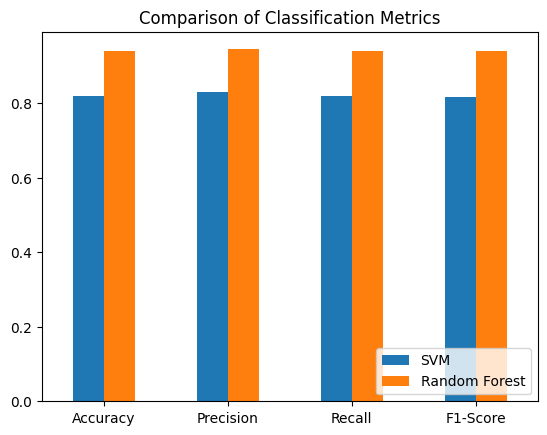

In [11]:
svm_predictions = grid_search_svm.predict(X_test)
rf_predictions = grid_search_rf.predict(X_test)

svm_report = classification_report(y_test, svm_predictions, output_dict=True)
rf_report = classification_report(y_test, rf_predictions, output_dict=True)

SVM_accuracy = svm_report['accuracy']
SVM_precision = svm_report['macro avg']['precision']
SVM_recall = svm_report['macro avg']['recall']
SVM_f1_score = svm_report['macro avg']['f1-score']

RF_accuracy = rf_report['accuracy']
RF_precision = rf_report['macro avg']['precision']
RF_recall = rf_report['macro avg']['recall']
RF_f1_score = rf_report['macro avg']['f1-score']

SVM_metrics = np.array([SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score])
RF_metrics = np.array([RF_accuracy, RF_precision, RF_recall, RF_f1_score])

index = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

df_metrics = pd.DataFrame({'SVM': SVM_metrics, 'Random Forest': RF_metrics}, index=index)

df_metrics.plot.bar(rot=0)
plt.legend(loc="lower right")
plt.title('Comparison of Classification Metrics')
plt.show()

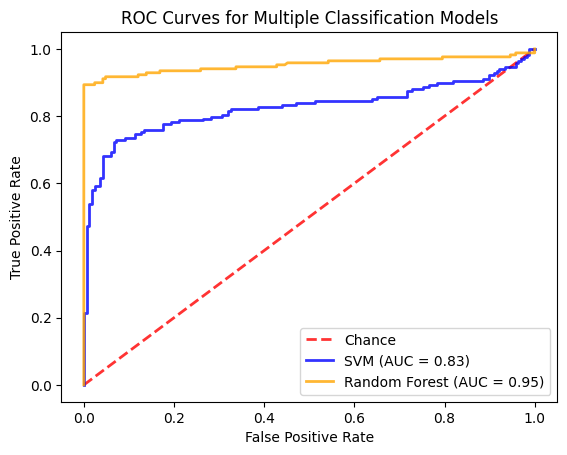

In [12]:
SVM_scores = grid_search_svm.decision_function(X_test)
RF_scores = grid_search_rf.predict_proba(X_test)[:, 1]

SVM_fpr, SVM_tpr, _ = roc_curve(y_test, SVM_scores)
SVM_auc = auc(SVM_fpr, SVM_tpr)

RF_fpr, RF_tpr, _ = roc_curve(y_test, RF_scores)
RF_auc = auc(RF_fpr, RF_tpr)

plt.figure()
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=0.8)
plt.plot(SVM_fpr, SVM_tpr, lw=2, color='blue', label=f'SVM (AUC = {SVM_auc:.2f})', alpha=0.8)
plt.plot(RF_fpr, RF_tpr, lw=2, color='orange', label=f'Random Forest (AUC = {RF_auc:.2f})', alpha=0.8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc="lower right")
plt.show()